<a href="https://colab.research.google.com/github/erkulev/erk/blob/main/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%BE%D0%BF%D0%BE%D1%80%D0%BD%D1%8B%D1%85_%D0%B2%D0%B5%D0%BA%D1%82%D0%BE%D1%80%D0%BE%D0%B2_support_vector_machines_SVM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# use seaborn plotting defaults
import seaborn as sns; sns.set()

Мы найдем прямую или кривую (в двумерном пространстве) или многообразие (в многомерном пространстве), отделяющее классы друг от друга.

Метод опорных векторов предоставляет способ решения этой проблемы. Идея заключается в следующем: вместо того чтобы рисовать между классами прямую нулевой ширины, можно нарисовать около каждой из прямых отступ (margin) некоторой ширины, простирающийся до ближайшей точки.

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


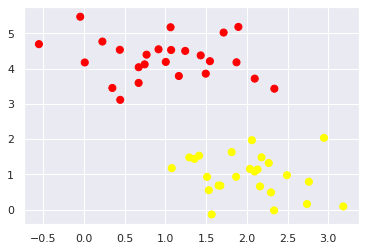

In [ ]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

Показаны три очень разных разделителя, тем не менее прекрасно разделяющих наши выборки. В зависимости от того, какой из них вы выберете, новой точке данных (например, отмеченной знаком «X» ) будут присвоены различные метки!

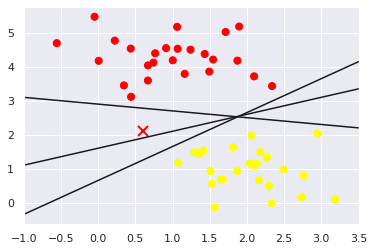

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

plt.xlim(-1, 3.5);

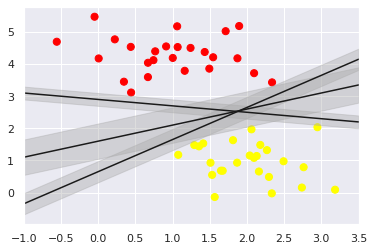

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')

for m, b, d in [(1, 0.65, 0.33), (0.5, 1.6, 0.55), (-0.2, 2.9, 0.2)]:
    yfit = m * xfit + b
    plt.plot(xfit, yfit, '-k')
    plt.fill_between(xfit, yfit - d, yfit + d, edgecolor='none',
                     color='#AAAAAA', alpha=0.4)

plt.xlim(-1, 3.5);

В методе опорных векторов в качестве оптимальной модели выбирается линия, максимизирующая этот отступ. Метод опорных векторов — пример оценивателя с максимальным отступом (maximum margin estimator).


воспользуемся классификатором на основе метода опорных векторов для обучения SVM-модели на них. Пока мы будем использовать линейное ядро и зададим очень большое значение параметра C (что это значит, мы расскажем далее):

In [ ]:
from sklearn.svm import SVC # "Support vector classifier"
model = SVC(kernel='linear', C=1E10)
model.fit(X, y)

SVC(C=10000000000.0, break_ties=False, cache_size=200, class_weight=None,
    coef0=0.0, decision_function_shape='ovr', degree=3, gamma='scale',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

Для лучшей визуализации происходящего создадим простую и удобную функцию для построения графика границ решений метода SVM

In [ ]:
def plot_svc_decision_function(model, ax=None, plot_support=True):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    # create grid to evaluate model
    x = np.linspace(xlim[0], xlim[1], 30)
    y = np.linspace(ylim[0], ylim[1], 30)
    Y, X = np.meshgrid(y, x)
    xy = np.vstack([X.ravel(), Y.ravel()]).T
    P = model.decision_function(xy).reshape(X.shape)
    
    # plot decision boundary and margins
    ax.contour(X, Y, P, colors='k',
               levels=[-1, 0, 1], alpha=0.5,
               linestyles=['--', '-', '--'])
    
    # plot support vectors
    if plot_support:
        ax.scatter(model.support_vectors_[:, 0],
                   model.support_vectors_[:, 1],
                   s=300, linewidth=1, facecolors='none');
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

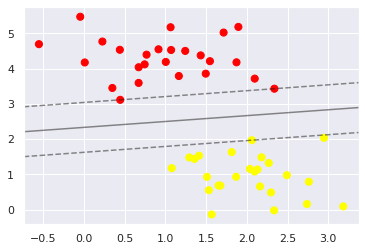

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(model);

Эта разделяющая линия максимизирует отступ между двумя наборами точек. Обратите внимание, что некоторые из обучающих точек лишь касаются отступа. Эти точки — ключевые элементы аппроксимации, они известны под названием опорных векторов (support vectors), в их честь алгоритм и получил свое название. В библиотеке Scikit-Learn данные об этих точках хранятся в атрибуте support_vectors_ классификатора

In [ ]:
model.support_vectors_

array([[0.44359863, 3.11530945],
       [2.33812285, 3.43116792],
       [2.06156753, 1.96918596]])

Ключ к успеху классификатора в том, что значение имеет только расположение опорных векторов. Все, находящиеся на правильной стороне, но дальше от отступа,
точки не меняют аппроксимацию! Формально дело в том, что эти точки не вносят вклада в используемую для обучения модели функцию потерь, так что их расположение и количество не имеет значения, если они не пересекают отступов.

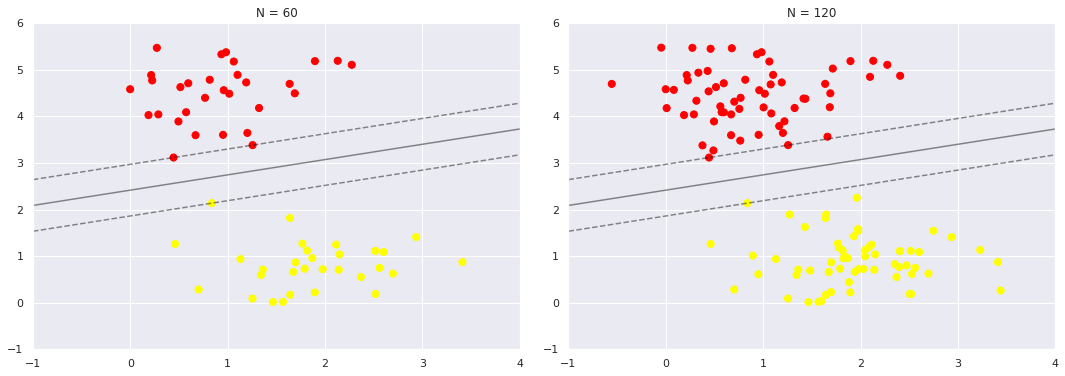

In [ ]:
def plot_svm(N=10, ax=None):
    X, y = make_blobs(n_samples=200, centers=2,
                      random_state=0, cluster_std=0.60)
    X = X[:N]
    y = y[:N]
    model = SVC(kernel='linear', C=1E10)
    model.fit(X, y)
    
    ax = ax or plt.gca()
    ax.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    ax.set_xlim(-1, 4)
    ax.set_ylim(-1, 6)
    plot_svc_decision_function(model, ax)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)
for axi, N in zip(ax, [60, 120]):
    plot_svm(N, axi)
    axi.set_title('N = {0}'.format(N))

In [ ]:
from ipywidgets import interact, fixed
interact(plot_svm, N=[10, 200], ax=fixed(None));

interactive(children=(Dropdown(description='N', options=(10, 200), value=10), Output()), _dom_classes=('widget…

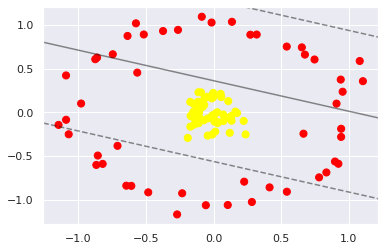

In [ ]:
from sklearn.datasets.samples_generator import make_circles
X, y = make_circles(100, factor=.1, noise=.1)

clf = SVC(kernel='linear').fit(X, y)

plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf, plot_support=False);

В случае нелинейных границ линейный классификатор неэффективен

попытаться спроецировать эти данные в пространство более высокой размерности, поэтому линейного разделителя будет достаточно. Например, одна из подходящих простых проекций — вычисление радиальной базисной функции, центрированной по середине совокупности данных:

In [ ]:
r = np.exp(-(X ** 2).sum(1))

In [ ]:
from mpl_toolkits import mplot3d

def plot_3D(elev=30, azim=30, X=X, y=y):
    ax = plt.subplot(projection='3d')
    ax.scatter3D(X[:, 0], X[:, 1], r, c=y, s=50, cmap='autumn')
    ax.view_init(elev=elev, azim=azim)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_zlabel('r')

interact(plot_3D, elev=[-90, 90], azip=(-180, 180),
         X=fixed(X), y=fixed(y));

interactive(children=(Dropdown(description='elev', options=(-90, 90), value=-90), IntSlider(value=30, descript…

Нам пришлось тщательно выбрать и внимательно настроить нашу проекцию: если бы мы не центрировали радиальную базисную функцию должным образом, то не получили бы столь «чистых», разделяемых линейно результатов. Необходимость подобного выбора — задача, требующая решения: хотелось бы каким-то образом автоматически находить оптимальные базисные функции.
Одна из применяемых с этой целью стратегий состоит в вычислении базисных функций, центрированных по каждой из точек набора данных, с тем чтобы далее алгоритм SVM проанализировал полученные результаты. Эта разновидность преобразования базисных функций, известная под названием преобразования ядра (kernel transformation), основана на отношении подобия (или ядре) между каждой парой точек.
Потенциальная проблема с этой методикой — проекцией N точек на N измерений — состоит в том, что при росте N она может потребовать колоссальных объемов вычислений. Однако благодаря изящной процедуре, известной под названием kernel trick (https://en.wikipedia.org/wiki/Kernel_method), обучение на преобразованных с помощью ядра данных можно произвести неявно, то есть даже без построения полного N-мерного представления ядерной проекции! Этот kernel trick является частью SVM и одной из причин мощи этого метода.
В библиотеке Scikit-Learn, чтобы применить алгоритм SVM с использованием ядерного преобразования, достаточно просто заменить линейное ядро на ядро RBF (radial basis function — «радиальная базисная функция») с помощью гиперпараметра модели kernel

In [ ]:
clf = SVC(kernel='rbf', C=1E6)
clf.fit(X, y)

SVC(C=1000000.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

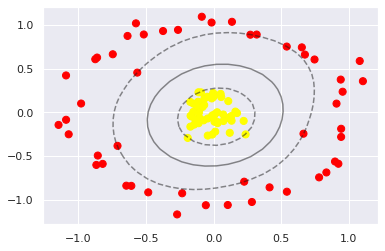

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=300, lw=1, facecolors='none');

С помощью этого ядерного метода опорных векторов мы можем определить подходящую нелинейную границу решений. Такая методика ядерного преобразования часто используется в машинном обучении для превращения быстрых линейных методов в быстрые нелинейные, особенно для моделей, в которых можно воспользоваться kernel trick.

Настройка SVM: размытие отступов

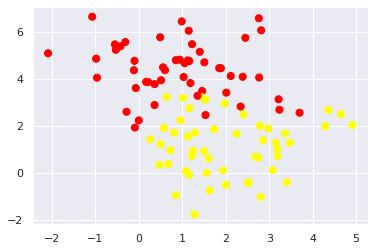

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn');

На этот случай в реализации метода SVM есть небольшой поправочный параметр для «размытия» отступа. Данный параметр разрешает некоторым точкам «заходить» на отступ в тех случаях, когда это приводит к лучшей аппроксимации. Степень размытости отступа управляется настроечным параметром, известным под названием C. При очень большом значении параметра C отступ является «жестким» и точки не могут находиться на нем. При меньшем значении параметра C отступ становится более размытым и может включать в себя некоторые точки.

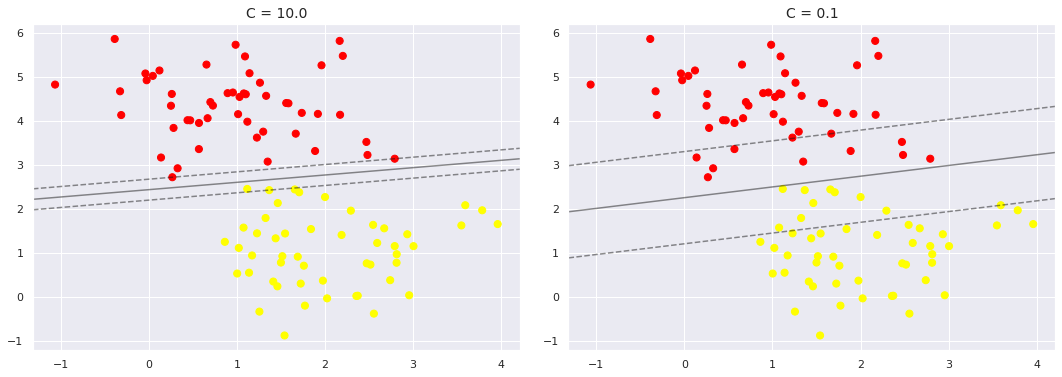

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=0.8)

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

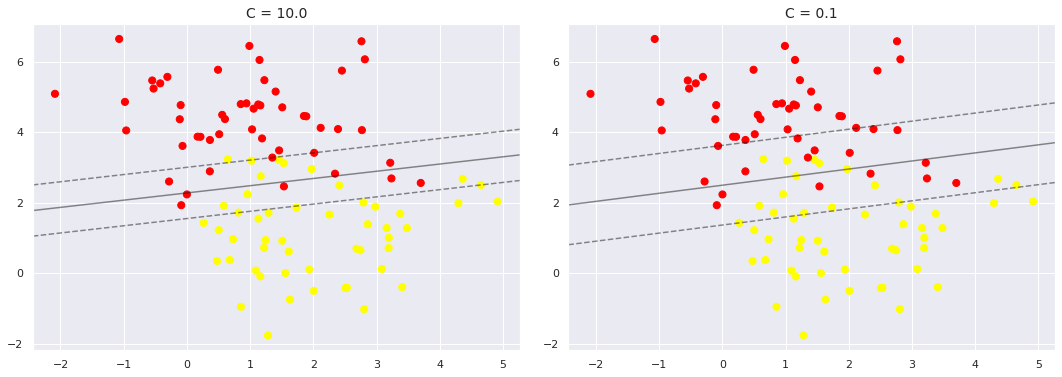

In [ ]:
X, y = make_blobs(n_samples=100, centers=2,
                  random_state=0, cluster_std=1.2)
fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for axi, C in zip(ax, [10.0, 0.1]):
    model = SVC(kernel='linear', C=C).fit(X, y)
    axi.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
    plot_svc_decision_function(model, axi)
    axi.scatter(model.support_vectors_[:, 0],
                model.support_vectors_[:, 1],
                s=300, lw=1, facecolors='none');
    axi.set_title('C = {0:.1f}'.format(C), size=14)

Пример: распознавание лиц

In [ ]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=60)
print(faces.target_names)
print(faces.images.shape)

['Ariel Sharon' 'Colin Powell' 'Donald Rumsfeld' 'George W Bush'
 'Gerhard Schroeder' 'Hugo Chavez' 'Junichiro Koizumi' 'Tony Blair']
(1348, 62, 47)


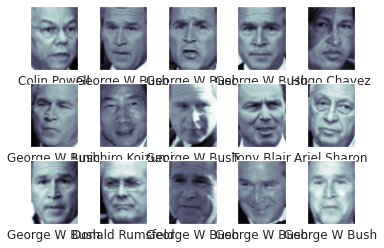

In [ ]:
fig, ax = plt.subplots(3, 5)
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='bone')
    axi.set(xticks=[], yticks=[],
            xlabel=faces.target_names[faces.target[i]])

Каждое изображение содержит 62 × 47, то есть примерно 3000 пикселов. Мы можем рассматривать каждый пиксел как признак, но эффективнее использовать какой-либо препроцессор для извлечения более осмысленных признаков. В данном случае мы воспользуемся методом главных компонент (см. раздел «Заглянем глубже: метод главных компонент» данной главы) для извлечения 150 базовых компонент,которые мы передадим нашему классификатору на основе метода опорных векторов. Упростим эту задачу, объединив препроцессор и классификатор в единый конвейер:

In [ ]:
!pip3 install pillow

In [ ]:
from sklearn.svm import SVC
from sklearn.decomposition import PCA as RandomizedPCA
from sklearn.pipeline import make_pipeline

pca = RandomizedPCA(n_components=150, svd_solver='randomized', whiten=True)
svc = SVC(kernel='rbf', class_weight='balanced')
model = make_pipeline(pca, svc)

Для контроля результатов работы нашего классификатора разобьем данные на обучающую и контрольную последовательности:

In [ ]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(faces.data, faces.target,
                                                random_state=42)

Наконец, воспользуемся поиском по сетке с перекрестной проверкой для анализа сочетаний параметров. Подберем значения параметров C (управляющего размытием отступов) и gamma (управляющего размером ядра радиальной базисной функции) и определим оптимальную модель:

In [ ]:
from sklearn.model_selection import GridSearchCV
param_grid = {'svc__C': [1, 5, 10, 50],
              'svc__gamma': [0.0001, 0.0005, 0.001, 0.005]}
grid = GridSearchCV(model, param_grid)

%time grid.fit(Xtrain, ytrain)
print(grid.best_params_)


CPU times: user 1min 12s, sys: 41 s, total: 1min 53s
Wall time: 1min 8s
{'svc__C': 10, 'svc__gamma': 0.001}


In [ ]:
model = grid.best_estimator_
yfit = model.predict(Xtest)

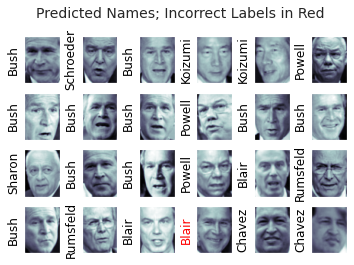

In [ ]:
fig, ax = plt.subplots(4, 6)
for i, axi in enumerate(ax.flat):
    axi.imshow(Xtest[i].reshape(62, 47), cmap='bone')
    axi.set(xticks=[], yticks=[])
    axi.set_ylabel(faces.target_names[yfit[i]].split()[-1],
                   color='black' if yfit[i] == ytest[i] else 'red')
fig.suptitle('Predicted Names; Incorrect Labels in Red', size=14);

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(ytest, yfit,
                            target_names=faces.target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.67      0.80      0.73        15
     Colin Powell       0.81      0.88      0.85        68
  Donald Rumsfeld       0.79      0.84      0.81        31
    George W Bush       0.92      0.86      0.89       126
Gerhard Schroeder       0.90      0.78      0.84        23
      Hugo Chavez       0.94      0.75      0.83        20
Junichiro Koizumi       0.91      0.83      0.87        12
       Tony Blair       0.79      0.90      0.84        42

         accuracy                           0.85       337
        macro avg       0.84      0.83      0.83       337
     weighted avg       0.86      0.85      0.85       337



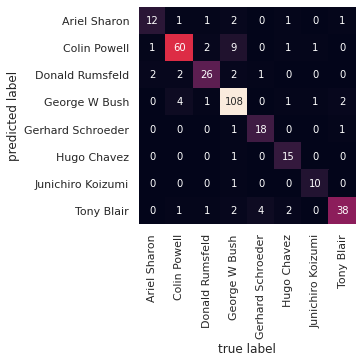

In [ ]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, yfit)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=faces.target_names,
            yticklabels=faces.target_names)
plt.xlabel('true label')
plt.ylabel('predicted label');

Эти методы являются мощными методами классификации по ряду причин.

-
Зависимость их от относительно небольшого количества опорных векторов означает компактность модели и небольшое количество используемой оперативной памяти.

-
Фаза предсказания после обучения модели занимает очень мало времени.

-
Поскольку на работу этих методов влияют только точки, находящиеся возле отступа, они хорошо подходят для многомерных данных — даже данных с количеством измерений большим, чем количество выборок, — непростые условия работы для других алгоритмов.

-
Интеграция с ядерными методами делает их универсальными, обеспечивает приспособляемость к множеству типов данных.

Однако у методов опорных векторов есть и несколько недостатков.

-
Они масштабируются при количестве выборок N в наихудшем случае как O[N3] (O[N2] для более эффективных реализаций). При значительном количествеобучающих выборок вычислительные затраты могут оказаться непомерно высокими.

-
Результаты зависят от удачности выбора параметра размытия C. Его необходимо тщательно выбирать с помощью перекрестной проверки, которая тоже может потребовать значительных вычислительных затрат при росте размеров наборов данных.

-
У результатов отсутствует непосредственная вероятностная интерпретация. Ее можно получить путем внутренней перекрестной проверки (см. параметр probability оценивателя SVC), но эта дополнительная оценка обходится недешево в смысле вычислительных затрат.

Учитывая эти особенности, я обращаюсь к SVM только тогда, когда более простые, быстрые и требующие меньшего количества настроек методы не удовлетворяют моим потребностям. Тем не менее, если у вас есть достаточно процессорного времени для выполнения обучения и перекрестной проверки SVM на ваших данных, этот метод может показать превосходные результаты.